In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, QiskitError
#from qiskit import execute, BasicAer
import qiskit.ignis.verification.randomized_benchmarking as rb
#import qiskit.test.benchmarks.randomized_benchmarking as br
import pyzx
from pyzx.circuit.qasmparser import QASMParser
from pyzx.circuit.qiskitqasmparser import QiskitQASMParser

In [36]:
#qc = rb.randomized_benchmarking_seq()
qc = rb.randomized_benchmarking_seq(nseeds=1, length_vector=None,
                                rb_pattern=[[0,1]],
                                length_multiplier=1, seed_offset=0,
                                align_cliffs=False,
                                interleaved_gates=None,
                                is_purity=False)
qc = qc[0][0][0]

In [37]:
# setting up the backend
# print(BasicAer.backends())

# running the job
# job_sim = execute(qc, BasicAer.get_backend('qasm_simulator'))
# sim_result = job_sim.result()

In [38]:
# print("\nPrint all gates:")
# [print(dat) for dat in qc.data]

In [39]:
qasm = qc.qasm()
### if you want to remove all barriers
## qasm = '\n'.join(['' if line.startswith("barrier") else line for line in qasm.splitlines()])

qc = qc.from_qasm_str(qasm)

print("\nPrint QASM:")
print(qasm)


Print QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];
cx qr[0],qr[1];
sdg qr[0];
h qr[0];
h qr[1];
s qr[1];
y qr[1];
barrier qr[0],qr[1];
y qr[1];
sdg qr[1];
h qr[1];
h qr[0];
s qr[0];
cx qr[0],qr[1];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];



In [40]:
# Draw the circuit
print(qc)

              ┌─────┐┌───┐      ░ ┌───┐ ┌───┐           ┌─┐   
qr_0: |0>──■──┤ Sdg ├┤ H ├──────░─┤ H ├─┤ S ├────────■──┤M├───
         ┌─┴─┐└┬───┬┘├───┤┌───┐ ░ ├───┤┌┴───┴┐┌───┐┌─┴─┐└╥┘┌─┐
qr_1: |0>┤ X ├─┤ H ├─┤ S ├┤ Y ├─░─┤ Y ├┤ Sdg ├┤ H ├┤ X ├─╫─┤M├
         └───┘ └───┘ └───┘└───┘ ░ └───┘└─────┘└───┘└───┘ ║ └╥┘
 cr_0: 0 ════════════════════════════════════════════════╩══╬═
                                                            ║ 
 cr_1: 0 ═══════════════════════════════════════════════════╩═
                                                              


In [41]:
p = QiskitQASMParser()
circ_list, whichpyzx = p.qiskitparse(qasm)
print(circ_list)
print(whichpyzx)
print(p.registers)

['qreg qr[2];', 'creg cr[2];', Circuit(2 qubits, 5 gates), 'y qr[1];', 'barrier qr[0],qr[1];', 'y qr[1];', Circuit(2 qubits, 5 gates), 'measure qr[0] -> cr[0];', 'measure qr[1] -> cr[1];']
[2, 6]
{'qr': (0, 2)}


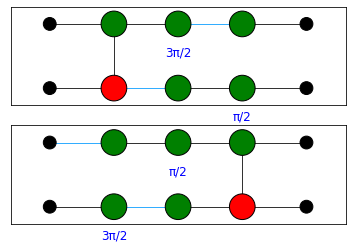

In [42]:
#qasm = qc.decompose().qasm()
pyzx.draw_many(circ_list, whichpyzx)

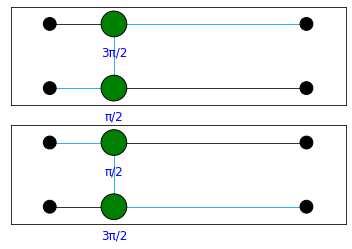

In [43]:
graph_list = [circ_list[w].to_graph() for w in whichpyzx]
[pyzx.full_reduce(g) for g in graph_list]
pyzx.draw_many(graph_list, range(len(whichpyzx)))

In [44]:
pyzx_circ_list = [pyzx.extract.streaming_extract(g) for g in graph_list]

for i in range(len(pyzx_circ_list)):
    prev = pyzx_circ_list[i]
    next = pyzx.extract.streaming_extract(graph_list[i])
    while prev.gates != next.gates:
        for j in range(len(next.gates))[::-1]:
            pyzx_circ_list[i].add_gate_to_front(next.gates[j])
        prev = next
        next = pyzx.extract.streaming_extract(graph_list[i])

pyzx_circ_list = [pyzx.optimize.basic_optimization(new_c.to_basic_gates()) for new_c in pyzx_circ_list]

pyzx_qasm = [new_c.to_basic_gates().to_qasm() for new_c in pyzx_circ_list]

passedAll = True
for i in range(len(pyzx_circ_list)):
    try:
        assert(pyzx.compare_tensors(pyzx_circ_list[i], circ_list[whichpyzx[i]]))
    except AssertionError:
        print(i)
        print(circ_list[whichpyzx[i]].__dict__)
        print(pyzx_circ_list[i].__dict__)
        passedAll = False
assert(passedAll)

In [45]:
pyzx_qasm = ["\n".join(['' if line.startswith("qreg") else line for line in circ.splitlines()[2:]]) for circ in pyzx_qasm]

for new_qasm in pyzx_qasm:
    [print(line) for line in new_qasm.splitlines()]
    print()


rz(1.5*pi) q[0];
h q[1];
rz(0.5*pi) q[1];
cz q[0], q[1];
h q[0];


rz(1.5*pi) q[1];
cx q[1], q[0];
h q[1];
h q[0];
rz(0.5*pi) q[0];



In [46]:
#now we need to map registers and glue all the pieces back together
for i in range(len(pyzx_qasm)):
    circ_list[whichpyzx[i]] = pyzx_qasm[i]
#print(circ_list)
## join the
qasm_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'+"\n".join(circ_list)
qasm_string = qasm_string.replace('q[', 'qr[')
print(qasm_string)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr[2];
creg cr[2];

rz(1.5*pi) qr[0];
h qr[1];
rz(0.5*pi) qr[1];
cz qr[0], qr[1];
h qr[0];
y qr[1];
barrier qr[0],qr[1];
y qr[1];

rz(1.5*pi) qr[1];
cx qr[1], qr[0];
h qr[1];
h qr[0];
rz(0.5*pi) qr[0];
measure qr[0] -> cr[0];
measure qr[1] -> cr[1];


In [47]:
# pqsl = [line + "\n" for line in pyzx_qasm] #took out .splitlines()
# qsl = [line + "\n" for line in qasm.splitlines()]
# # print(pqsl)
# # print(qsl)
# new_qasm = '\n'.join(qsl[0:4]) + ''.join(pqsl[3:]) + ''.join(qsl[-2:])
# new_qasm = new_qasm.replace('q[', 'qr[')
# print(new_qasm)

In [48]:
new_qc = qc.from_qasm_str(qasm_string)
print(new_qc)

         ┌────────────┐                 ┌───┐ ░                    ┌───┐┌───┐»
qr_0: |0>┤ Rz(1.5*pi) ├───────────────■─┤ H ├─░────────────────────┤ X ├┤ H ├»
         └───┬───┬────┘┌────────────┐ │ ├───┤ ░ ┌───┐┌────────────┐└─┬─┘├───┤»
qr_1: |0>────┤ H ├─────┤ Rz(0.5*pi) ├─■─┤ Y ├─░─┤ Y ├┤ Rz(1.5*pi) ├──■──┤ H ├»
             └───┘     └────────────┘   └───┘ ░ └───┘└────────────┘     └───┘»
 cr_0: 0 ════════════════════════════════════════════════════════════════════»
                                                                             »
 cr_1: 0 ════════════════════════════════════════════════════════════════════»
                                                                             »
«      ┌────────────┐┌─┐
«qr_0: ┤ Rz(0.5*pi) ├┤M├
«      └────┬─┬─────┘└╥┘
«qr_1: ─────┤M├───────╫─
«           └╥┘       ║ 
«cr_0: ══════╬════════╩═
«            ║          
«cr_1: ══════╩══════════
«                       


In [49]:
print(qc)

              ┌─────┐┌───┐      ░ ┌───┐ ┌───┐           ┌─┐   
qr_0: |0>──■──┤ Sdg ├┤ H ├──────░─┤ H ├─┤ S ├────────■──┤M├───
         ┌─┴─┐└┬───┬┘├───┤┌───┐ ░ ├───┤┌┴───┴┐┌───┐┌─┴─┐└╥┘┌─┐
qr_1: |0>┤ X ├─┤ H ├─┤ S ├┤ Y ├─░─┤ Y ├┤ Sdg ├┤ H ├┤ X ├─╫─┤M├
         └───┘ └───┘ └───┘└───┘ ░ └───┘└─────┘└───┘└───┘ ║ └╥┘
 cr_0: 0 ════════════════════════════════════════════════╩══╬═
                                                            ║ 
 cr_1: 0 ═══════════════════════════════════════════════════╩═
                                                              


In [50]:
import qiskit
from qiskit.providers.basicaer import QasmSimulatorPy
c1 = qiskit.execute(qc, QasmSimulatorPy()).result().get_counts()
c2 = qiskit.execute(new_qc, QasmSimulatorPy()).result().get_counts()

In [51]:
c1

{'00': 1024}

In [52]:
c2

{'00': 1024}

In [53]:
assert(c1 == c2)

In [54]:
qc.depth()

9

In [55]:
qc.size()

14

In [56]:
new_qc.depth()

10

In [57]:
new_qc.size()

14

In [58]:
new_new_qc = qiskit.transpile(qc, basis_gates=['u3', 'cx'], optimization_level=2)

In [59]:
print(new_new_qc)

                  ┌────────────┐    ░ ┌──────────────────┐     ┌─┐   
qr_0: |0>──■──────┤ U2(0,pi/2) ├────░─┤ U3(pi/2,pi/2,pi) ├──■──┤M├───
         ┌─┴─┐┌───┴────────────┴──┐ ░ ├──────────────────┤┌─┴─┐└╥┘┌─┐
qr_1: |0>┤ X ├┤ U3(pi/2,pi/2,2pi) ├─░─┤ U3(pi/2,pi,pi/2) ├┤ X ├─╫─┤M├
         └───┘└───────────────────┘ ░ └──────────────────┘└───┘ ║ └╥┘
 cr_0: 0 ═══════════════════════════════════════════════════════╩══╬═
                                                                   ║ 
 cr_1: 0 ══════════════════════════════════════════════════════════╩═
                                                                     


In [60]:
new_new_qc.depth()

5

In [61]:
new_new_qc.size()

8

In [62]:
doubly_qc = qiskit.transpile(new_qc, basis_gates=['u3', 'cx'], optimization_level=2)
print(doubly_qc)

              ┌───────────┐           ┌──────────┐  ░                  ┌───┐»
qr_0: |0>─────┤ U1(3pi/2) ├───────■───┤ U2(0,pi) ├──░──────────────────┤ X ├»
         ┌────┴───────────┴────┐┌─┴─┐┌┴──────────┴┐ ░ ┌───────────────┐└─┬─┘»
qr_1: |0>┤ U3(pi/2,-pi/2,pi/2) ├┤ X ├┤ U2(pi,2pi) ├─░─┤ U3(pi,0,pi/2) ├──■──»
         └─────────────────────┘└───┘└────────────┘ ░ └───────────────┘     »
 cr_0: 0 ═══════════════════════════════════════════════════════════════════»
                                                                            »
 cr_1: 0 ═══════════════════════════════════════════════════════════════════»
                                                                            »
«      ┌──────────────────┐┌─┐   
«qr_0: ┤ U3(pi/2,pi/2,pi) ├┤M├───
«      └───┬──────────┬───┘└╥┘┌─┐
«qr_1: ────┤ U2(0,pi) ├─────╫─┤M├
«          └──────────┘     ║ └╥┘
«cr_0: ═════════════════════╩══╬═
«                              ║ 
«cr_1: ════════════════════════╩═
«                         

In [63]:
doubly_qc.depth()

7

In [64]:
doubly_qc.size()

11

In [65]:
c3 = qiskit.execute(new_new_qc, QasmSimulatorPy()).result().get_counts()
c4 = qiskit.execute(doubly_qc, QasmSimulatorPy()).result().get_counts()
c3

{'00': 1024}

In [66]:
c4

{'00': 1024}